## Import

In [1]:
import os
import json
import numpy as np
import pandas as pd

from langchain_openai import ChatOpenAI

import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

from langchain_core.tools import tool

OPENAI_API_KEY: ········


## Init Geospatial Data

In [4]:
# POP data
import rasterio
from rasterio.transform import rowcol

input_file = 'data/gbr_pd_2020_1km_UNadj.tif'
#input_file = 'data/gbr_ppp_2020.tif'
bbox = (-0.57, 51.25, 0.37, 51.72) # London bbox
with rasterio.open(input_file) as src:
    data = src.read(1)
    transform = src.transform
    
    top_left = rowcol(transform, bbox[0], bbox[3])
    bottom_right = rowcol(transform, bbox[2], bbox[1])
    top_left = (int(top_left[0]), int(top_left[1]))
    bottom_right = (int(bottom_right[0]), int(bottom_right[1]))
    print(top_left, bottom_right)
    
    data_cropped = data[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]
    pop_flat_cropped = data_cropped.flatten()
    indices_cropped = np.nonzero(pop_flat_cropped > 0)[0]
    rows_cropped, cols_cropped = np.unravel_index(indices_cropped, data_cropped.shape)
    rows_adjusted = rows_cropped + top_left[0]
    cols_adjusted = cols_cropped + top_left[1]
    
    populations = [data[row, col] for row, col in zip(rows_adjusted, cols_adjusted)]
    center_coords = [tuple(reversed(rasterio.transform.xy(transform, row, col, offset='center'))) \
                    for row, col in zip(rows_adjusted, cols_adjusted)]
    ul_coords = [tuple(reversed(rasterio.transform.xy(transform, row, col, offset='ul'))) \
                    for row, col in zip(rows_adjusted, cols_adjusted)]
    ur_coords = [tuple(reversed(rasterio.transform.xy(transform, row, col, offset='ur'))) \
                    for row, col in zip(rows_adjusted, cols_adjusted)]
    ll_coords = [tuple(reversed(rasterio.transform.xy(transform, row, col, offset='ll'))) \
                    for row, col in zip(rows_adjusted, cols_adjusted)]
    lr_coords = [tuple(reversed(rasterio.transform.xy(transform, row, col, offset='lr'))) \
                    for row, col in zip(rows_adjusted, cols_adjusted)]
    
print(len(populations))
# save to numpy file for London populations
london_pops_file = 'data/london_pop.npz'
np.savez(london_pops_file, populations=populations, center_coords=center_coords, 
         ul_coords=ul_coords, ur_coords=ur_coords, ll_coords=ll_coords, lr_coords=lr_coords)

(1097, 969) (1153, 1082)
6325


In [24]:
def pop(city_name, top_k, desc=True):
    area_ids = []
    bbox_list = []
    if 'london' in city_name.lower():
        # read population numpy file
        london_pops_file = 'data/london_pop.npz'
        london_pops = np.load(london_pops_file)
        pop = london_pops['populations']
        ul_coords = london_pops['ul_coords']
        ur_coords = london_pops['ur_coords']
        ll_coords = london_pops['ll_coords']
        lr_coords = london_pops['lr_coords']
        center_coords = london_pops['center_coords']
        
        indices = list(range(len(pop)))
        indices.sort(key=lambda i: pop[i], reverse=(desc==True))
        for idx in indices[:top_k]:
            #print(pop[idx])
            area_ids.append(idx)
            bbox = (lr_coords[idx][1], lr_coords[idx][0], ul_coords[idx][1], ul_coords[idx][0])
            #print(bbox)
            bbox_list.append(bbox)
    print('area_ids_candidate:', area_ids)
    return area_ids, bbox_list


area_ids_candidate: [2644, 2643, 2446, 2757, 3215, 2660, 3221, 2559, 2758, 2672]


In [16]:
import requests
# https://github.com/geopy/geopy/issues/262
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="UrbanDevQA")
headers = geolocator.headers

def geo(bbox, query, limit=10):
    query = query.replace(' ','+')
    results = []
    viewbox = "{},{},{},{}".format(bbox[0], bbox[1], bbox[2], bbox[3])
    nominatim_url = f"https://nominatim.openstreetmap.org/search?q={query}&format=json&limit={limit}&viewbox={viewbox}&bounded=1"
    #print(nominatim_url)
    response = requests.get(nominatim_url, headers=headers)
    #print(response.text)
    data = json.loads(response.text)
    if 'error' in data:
        results.append(None)
    else:
        results.append(data)
    return results



## Define Tools

In [31]:
from typing import Any, Dict, List, Optional, Tuple, Union, cast

@tool
def search_population_density(city_name: str, top_k: int) -> str:
    """Using this tool to find top areas with the highest population density in a city. Each area is 1 km square.

    Parameters:
        city_name: The city name (for example: London)
        top_k: the number of top areas (for example: 5)

    Returns:
        List[Dict[str, Any]]: A list of AreaObject dictionaries containing the area id and
            bounding box of the area with the format (lat0, lng0, lat1, lng1). 
            lat0 and lng0 are the coordinates of the lower-right 
            and lat1 and lng1 are the coordinates of the upper-left of the area.
            
    Example
    -------
        >>> search_population_density("London", 10)
        [
            {'area_id': 2446, 'bbox': [0.04041666553887957,51.54124997447413,0.03208333223888005,51.54958330777413]},
        ]
    """
    print('get_population_density')
    area_ids, bbox_list = pop(city_name, top_k)
    results = []
    for idx in range(len(area_ids)):
        results.append({'area_id': area_ids[idx], 'bbox': bbox_list[idx]})
    return results


@tool
def check_within_area(area_obj: Dict[str, Any], query: str, condition: str) -> bool:
    """check if query objects exists within the AreaObject

    Parameters:
        area_obj(Dict[str, Any]): The area object to check within condition
        query: Query string to find objects. For example: use query='fast-food' to find fast-food restaurant within.
        condition: the Condition to check (for example: condition=’< 5’ to check if the number of query object within an area is less than 5.

    Returns:
        True or False
        
    Example
    -------
        >>> check_within_area({'area_id': 2446, 'bbox': [0.04041666553887957,51.54124997447413,0.03208333223888005,51.54958330777413]}, "fast-food", "< 5")
        True
    """
    print('check_within_area')
    area_id = area_obj['area_id']
    bbox = area_obj['bbox']
    
    tokens = condition.split(' ')
    cond = tokens[0].strip()
    limit = tokens[1].strip()
    limit = int(limit)
    # call geospatial tool
    results = geo(bbox, query, limit)
    
    if len(results) < limit:
        return True
    else:
        return False

@tool
def check_near_by_area(area_obj: Dict[str, Any], query: str, condition: str) -> bool:
    """check if query objects exists nearby the AreaObject

    Parameters:
        area_obj(Dict[str, Any]): The area object to check nearby condition
        query: Query string to find objects. For example: use query='amenity=school' to find schools nearby.
        condition: The condition to check. For example: condition='distance > 400m' to check if query object exists nearby an area by 400m. 

    Returns:
        True or False
        
    Example
    -------
        >>> check_near_by_area({'area_id': 2446, 'bbox': [0.04041666553887957,51.54124997447413,0.03208333223888005,51.54958330777413]}, "amenity=school", "distance > 400m")
        True
    """
    print('check_near_by_area')
    import re
    tokens = re.split(' > ', condition)
    distance = tokens[-1].strip()
    distance = int(re.search(r'\d+', distance).group())
    
    area_id = area_obj['area_id']
    bbox = area_obj['bbox']
    # compute new boundingbox from AreaObject with distance
    import geopy.distance
    left_point = (bbox[0], bbox[1])
    # go East first
    new_left_point = geopy.distance.distance(meters=distance).destination(left_point, bearing=90)
    new_left_point = (new_left_point[0], new_left_point[1])
    # then go north
    new_left_point = geopy.distance.distance(meters=distance).destination(new_left_point, bearing=90)
    
    right_point = (bbox[2], bbox[3])
    # go West first
    new_right_point = geopy.distance.distance(meters=distance).destination(right_point, bearing=-90)
    new_right_point = (new_right_point[0], new_right_point[1])
    # then go south
    new_right_point = geopy.distance.distance(meters=distance).destination(new_right_point, bearing=180)
    
    new_bbox = (new_left_point[0], new_left_point[1], new_right_point[0], new_right_point[1])
    # call geospatial tool
    results = geo(new_bbox, query)
    if len(results) > 0:
        return True
    else:
        return False
    

tools = [search_population_density, check_within_area, check_near_by_area]


## ReAct with instruction prompts

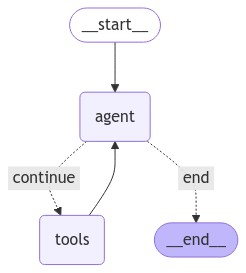

In [32]:
from langgraph.prebuilt import create_react_agent

system_prompt = """For the given question, you should follow the following steps:
1. Find high density: find high foot traffic areas in London. Call them as candidate areas.
2. Check less competitions: find the area from list of candidate areas that has less competitions.
3. Check by urban regulation: find the area from list of candidate areas that do not have any schools nearby.
4. You should only run tools step-by-step, do not run multiple tools at the same time.
"""
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0, api_key=OPENAI_API_KEY)
graph = create_react_agent(llm, tools=tools, state_modifier=system_prompt)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [ ]:
query = "Please recommend three locations in London for a new fast-food restaurant."
inputs = {"messages": [("user", query)]}
print_stream(graph.stream(inputs, stream_mode="values"))


## ReAct without instruction prompts

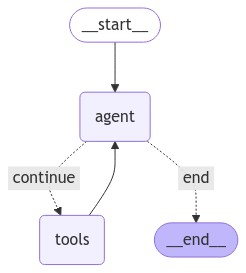

In [12]:
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0, api_key=OPENAI_API_KEY)
graph = create_react_agent(llm, tools=tools)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [ ]:
query = "Please recommend three locations in London for a new fast-food restaurant."
inputs = {"messages": [("user", query)]}
print_stream(graph.stream(inputs, stream_mode="values"))
